![](grid.png)

# ELC-144x142x79
---

Test with initial condition (on Jean-Zay):
> /gpfsstore/rech/goe/ufz23bm/IGCM_OUT/LMDZ/ELC-144x142x79/ATM/Output

that I created with 

> EXPERIMENTS/LMDZ/CREATE_clim_360d/config.card

Ce fichier va chercher le fichier Relief.nc suivant : `/gpfswork/rech/psl/commun/IGCM/ATM/Relief.nc`

that I copie on CICLAD: 

> /data/mlalande/ELC-144x142x79_clim


amip_CMIP6 -> /gpfswork/rech/psl/commun/IGCM//ATM/START/eORCA1.2xLMD144x142/startphy_eORCA1.2xLMD144x142x79_o2a_v3.nc

### Import modules

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '../../') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

3.8.2 | packaged by conda-forge | (default, Feb 28 2020, 17:15:22) 
[GCC 7.3.0]
Virtual memory usage - total: 126 GB / available: 108 GB / percent used: 13.8 %


In [5]:
path = '/data/mlalande/ELC-144x142x79_clim/Output'

limit = xr.open_dataset(path+'/Boundary/ELC-144x142x79_clim_limit.nc')
grilles_gcm = xr.open_dataset(path+'/Grid/ELC-144x142x79_grilles_gcm.nc')
start = xr.open_dataset(path+'/Restart/ELC-144x142x79_clim_start.nc')
startphy = xr.open_dataset(path+'/Restart/ELC-144x142x79_clim_startphy.nc')

In [4]:
limit

<xarray.Dataset>
Dimensions:    (points_physiques: 20306, time: 360)
Dimensions without coordinates: points_physiques, time
Data variables:
    TEMPS      (time) float64 ...
    FOCE       (time, points_physiques) float64 ...
    FSIC       (time, points_physiques) float64 ...
    FTER       (time, points_physiques) float64 ...
    FLIC       (time, points_physiques) float64 ...
    SST        (time, points_physiques) float64 ...
    BILS       (time, points_physiques) float64 ...
    ALB        (time, points_physiques) float64 ...
    RUG        (time, points_physiques) float64 ...
    longitude  (points_physiques) float32 ...
    latitude   (points_physiques) float32 ...
Attributes:
    title:    Fichier conditions aux limites
    history:  File produced using ce0l executable.\nSea Ice Concentration bui...

In [20]:
grilles_gcm

<xarray.Dataset>
Dimensions:   (latu: 143, latv: 142, lev: 79, lonu: 145, lonv: 145)
Coordinates:
  * lonu      (lonu) float32 181.25 183.75 186.25 ... 536.25 538.75 541.25
  * lonv      (lonv) float32 180.0 182.5 185.0 187.5 ... 532.5 535.0 537.5 540.0
  * latu      (latu) float32 90.0 88.73239 87.46479 ... -88.73239 -90.0
  * latv      (latv) float32 89.366196 88.098595 ... -88.098595 -89.366196
Dimensions without coordinates: lev
Data variables:
    grille_u  (latu, lonu) float32 ...
    grille_v  (latv, lonv) float32 ...
    grille_s  (latu, lonv) float32 ...
    presnivs  (lev) float32 ...
    phis      (latu, lonv) float32 ...
    aire      (latu, lonv) float32 109347330.0 109347330.0 ... 109347330.0
    mask      (latu, lonv) int32 ...

In [21]:
start

<xarray.Dataset>
Dimensions:   (index: 100, rlatu: 143, rlatv: 142, rlonu: 145, rlonv: 145, sig: 80, sigs: 79, temps: 1)
Coordinates:
  * rlonu     (rlonu) float64 -3.12 -3.076 -3.033 -2.989 ... 3.076 3.12 3.163
  * rlatu     (rlatu) float64 1.571 1.549 1.527 1.504 ... -1.527 -1.549 -1.571
  * rlonv     (rlonv) float64 -3.142 -3.098 -3.054 -3.011 ... 3.054 3.098 3.142
  * rlatv     (rlatv) float64 1.56 1.538 1.515 1.493 ... -1.515 -1.538 -1.56
  * temps     (temps) datetime64[ns] 1979-01-01
Dimensions without coordinates: index, sig, sigs
Data variables:
    controle  (index) float64 ...
    nivsigs   (sigs) float64 ...
    nivsig    (sig) float64 ...
    ap        (sig) float64 ...
    bp        (sig) float64 ...
    presnivs  (sigs) float64 ...
    cu        (rlatu, rlonu) float64 ...
    cv        (rlatv, rlonv) float64 ...
    aire      (rlatu, rlonv) float64 1.084e+08 1.084e+08 ... 1.084e+08 1.084e+08
    phisinit  (rlatu, rlonv) float64 ...
    ucov      (temps, sigs, rlatu, rlonu) float64 ...
    vcov      (temps, sigs, rlatv, rlonv) float64 ...
    teta      (temps, sigs, rlatu, rlonv) float64 ...
    H2Ov      (temps, sigs, rlatu, rlonv) float64 ...
    H2Ol      (temps, sigs, rlatu, rlonv) float64 ...
    H2Oi      (temps, sigs, rlatu, rlonv) float64 ...
    Aga       (temps, sigs, rlatu, rlonv) float64 ...
    masse     (temps, sigs, rlatu, rlonv) float64 ...
    ps        (temps, rlatu, rlonv) float64 ...
Attributes:
    title:    Fichier demarrage dynamique

In [32]:
# Create the right dimension for topo (without the duplicated longitude)
topo = grilles_gcm.aire[:,:-1].copy()
topo.name = 'ZMEA'
topo.attrs['units'] = 'm'
topo.attrs['long_name'] = 'MEAN OROGRAPHY'
topo

<xarray.DataArray 'ZMEA' (latu: 143, lonv: 144)>
array([[1.0934733e+08, 1.0934733e+08, 1.0934733e+08, ..., 1.0934733e+08,
        1.0934733e+08, 1.0934733e+08],
       [8.7469837e+08, 8.7469837e+08, 8.7469837e+08, ..., 8.7469837e+08,
        8.7469837e+08, 8.7469837e+08],
       [1.7489686e+09, 1.7489686e+09, 1.7489686e+09, ..., 1.7489686e+09,
        1.7489686e+09, 1.7489686e+09],
       ...,
       [1.7489686e+09, 1.7489686e+09, 1.7489686e+09, ..., 1.7489686e+09,
        1.7489686e+09, 1.7489686e+09],
       [8.7469837e+08, 8.7469837e+08, 8.7469837e+08, ..., 8.7469837e+08,
        8.7469837e+08, 8.7469837e+08],
       [1.0934733e+08, 1.0934733e+08, 1.0934733e+08, ..., 1.0934733e+08,
        1.0934733e+08, 1.0934733e+08]], dtype=float32)
Coordinates:
  * lonv     (lonv) float32 180.0 182.5 185.0 187.5 ... 530.0 532.5 535.0 537.5
  * latu     (latu) float32 90.0 88.73239 87.46479 ... -87.46479 -88.73239 -90.0
Attributes:
    units:      m
    long_name:  MEAN OROGRAPHY

In [33]:
topo[0]

<xarray.DataArray 'ZMEA' (lonv: 144)>
array([1.0934733e+08, 1.0934733e+08, 1.0934733e+08, 1.0934733e+08,
       1.0934733e+08, 1.0934733e+08, 1.0934733e+08, 1.0934733e+08,
       1.0934733e+08, 1.0934733e+08, 1.0934733e+08, 1.0934733e+08,
       1.0934733e+08, 1.0934733e+08, 1.0934733e+08, 1.0934733e+08,
       1.0934733e+08, 1.0934733e+08, 1.0934733e+08, 1.0934733e+08,
       1.0934733e+08, 1.0934733e+08, 1.0934733e+08, 1.0934733e+08,
       1.0934733e+08, 1.0934733e+08, 1.0934733e+08, 1.0934733e+08,
       1.0934733e+08, 1.0934733e+08, 1.0934733e+08, 1.0934733e+08,
       1.0934733e+08, 1.0934733e+08, 1.0934733e+08, 1.0934733e+08,
       1.0934733e+08, 1.0934733e+08, 1.0934733e+08, 1.0934733e+08,
       1.0934733e+08, 1.0934733e+08, 1.0934733e+08, 1.0934733e+08,
       1.0934733e+08, 1.0934733e+08, 1.0934733e+08, 1.0934733e+08,
       1.0934733e+08, 1.0934733e+08, 1.0934733e+08, 1.0934733e+08,
       1.0934733e+08, 1.0934733e+08, 1.0934733e+08, 1.0934733e+08,
       1.0934733e+08, 1.0934733e+08, 1.0934733e+08, 1.0934733e+08,
       1.0934733e+08, 1.0934733e+08, 1.0934733e+08, 1.0934733e+08,
       1.0934733e+08, 1.0934733e+08, 1.0934733e+08, 1.0934733e+08,
       1.0934733e+08, 1.0934733e+08, 1.0934733e+08, 1.0934733e+08,
       1.0934733e+08, 1.0934733e+08, 1.0934733e+08, 1.0934733e+08,
       1.0934733e+08, 1.0934733e+08, 1.0934733e+08, 1.0934733e+08,
       1.0934733e+08, 1.0934733e+08, 1.0934733e+08, 1.0934733e+08,
       1.0934733e+08, 1.0934733e+08, 1.0934733e+08, 1.0934733e+08,
       1.0934733e+08, 1.0934733e+08, 1.0934733e+08, 1.0934733e+08,
       1.0934733e+08, 1.0934733e+08, 1.0934733e+08, 1.0934733e+08,
       1.0934733e+08, 1.0934733e+08, 1.0934733e+08, 1.0934733e+08,
       1.0934733e+08, 1.0934733e+08, 1.0934733e+08, 1.0934733e+08,
       1.0934733e+08, 1.0934733e+08, 1.0934733e+08, 1.0934733e+08,
       1.0934733e+08, 1.0934733e+08, 1.0934733e+08, 1.0934733e+08,
       1.0934733e+08, 1.0934733e+08, 1.0934733e+08, 1.0934733e+08,
       1.0934733e+08, 1.0934733e+08, 1.0934733e+08, 1.0934733e+08,
       1.0934733e+08, 1.0934733e+08, 1.0934733e+08, 1.0934733e+08,
       1.0934733e+08, 1.0934733e+08, 1.0934733e+08, 1.0934733e+08,
       1.0934733e+08, 1.0934733e+08, 1.0934733e+08, 1.0934733e+08,
       1.0934733e+08, 1.0934733e+08, 1.0934733e+08, 1.0934733e+08,
       1.0934733e+08, 1.0934733e+08, 1.0934733e+08, 1.0934733e+08,
       1.0934733e+08, 1.0934733e+08, 1.0934733e+08, 1.0934733e+08],
      dtype=float32)
Coordinates:
  * lonv     (lonv) float32 180.0 182.5 185.0 187.5 ... 530.0 532.5 535.0 537.5
    latu     float32 90.0
Attributes:
    units:      m
    long_name:  MEAN OROGRAPHY

In [40]:
startphy.ZMEA[0]

<xarray.DataArray 'ZMEA' ()>
array(0.)
Attributes:
    title:    ZMEA

In [34]:
# Dupplicate the first value North Pole 90°N
topo[0] = startphy.ZMEA[0]
topo[0]

<xarray.DataArray 'ZMEA' (lonv: 144)>
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)
Coordinates:
  * lonv     (lonv) float32 180.0 182.5 185.0 187.5 ... 530.0 532.5 535.0 537.5
    latu     float32 90.0
Attributes:
    units:      m
    long_name:  MEAN OROGRAPHY

In [36]:
topo

<xarray.DataArray 'ZMEA' (latu: 143, lonv: 144)>
array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [8.7469837e+08, 8.7469837e+08, 8.7469837e+08, ..., 8.7469837e+08,
        8.7469837e+08, 8.7469837e+08],
       [1.7489686e+09, 1.7489686e+09, 1.7489686e+09, ..., 1.7489686e+09,
        1.7489686e+09, 1.7489686e+09],
       ...,
       [1.7489686e+09, 1.7489686e+09, 1.7489686e+09, ..., 1.7489686e+09,
        1.7489686e+09, 1.7489686e+09],
       [8.7469837e+08, 8.7469837e+08, 8.7469837e+08, ..., 8.7469837e+08,
        8.7469837e+08, 8.7469837e+08],
       [1.0934733e+08, 1.0934733e+08, 1.0934733e+08, ..., 1.0934733e+08,
        1.0934733e+08, 1.0934733e+08]], dtype=float32)
Coordinates:
  * lonv     (lonv) float32 180.0 182.5 185.0 187.5 ... 530.0 532.5 535.0 537.5
  * latu     (latu) float32 90.0 88.73239 87.46479 ... -87.46479 -88.73239 -90.0
Attributes:
    units:      m
    long_name:  MEAN OROGRAPHY

In [57]:
# Without the Poles
topo[1:-1,:]

<xarray.DataArray 'ZMEA' (latu: 141, lonv: 144)>
array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 8.7469837e+08],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 1.7489686e+09],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 2.6223828e+09],
       ...,
       [9.8106470e+02, 8.4459381e+02, 7.4621057e+02, ..., 2.3112490e+03,
        2.2157397e+03, 2.6223828e+09],
       [2.0891641e+03, 1.9300353e+03, 1.7702162e+03, ..., 2.8325352e+03,
        2.7997825e+03, 1.7489686e+09],
       [2.7578831e+03, 2.7029546e+03, 2.6303313e+03, ..., 2.9535305e+03,
        2.9399067e+03, 8.7469837e+08]], dtype=float32)
Coordinates:
  * lonv     (lonv) float32 180.0 182.5 185.0 187.5 ... 530.0 532.5 535.0 537.5
  * latu     (latu) float32 88.73239 87.46479 86.19718 ... -87.46479 -88.73239
Attributes:
    units:      m
    long_name:  MEAN OROGRAPHY

In [58]:
# Fill all the values except the poles
k=0
for lat in range(topo[1:-1,:].latu.size):
    for lon in range(topo[1:-1,:].lonv.size):
        topo[1:-1,:][lat,lon] = startphy.ZMEA[k+1]
        k += 1

In [59]:
k

20304

In [46]:
startphy.points_physiques.size

20306

Parfait il manque just les 2 points des poles

In [64]:
# Duplicate the South Pole (-90°)
topo[-1] = startphy.ZMEA[-1]

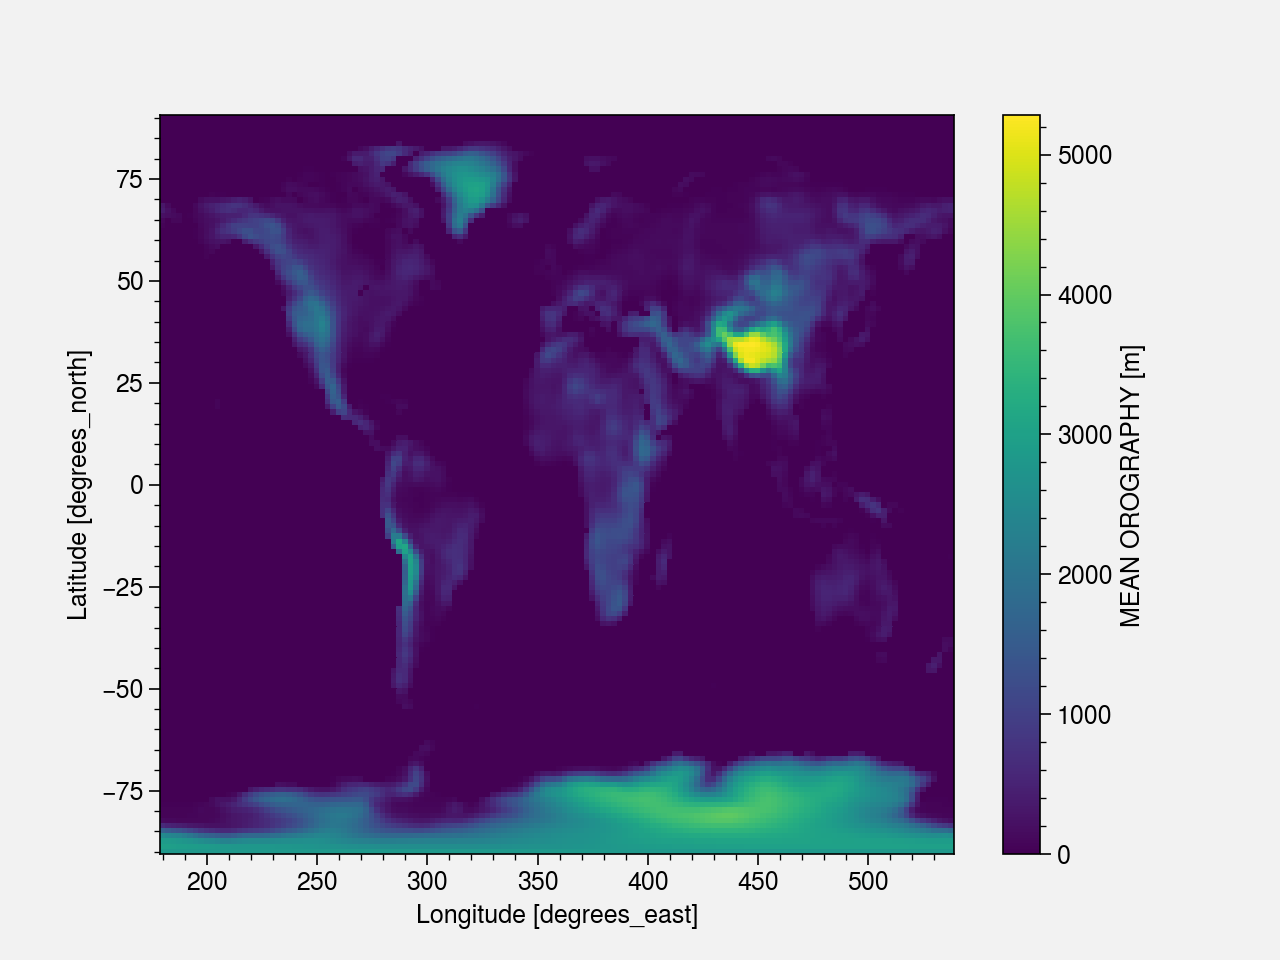

In [66]:
topo.plot()

Décallage des longitude ?

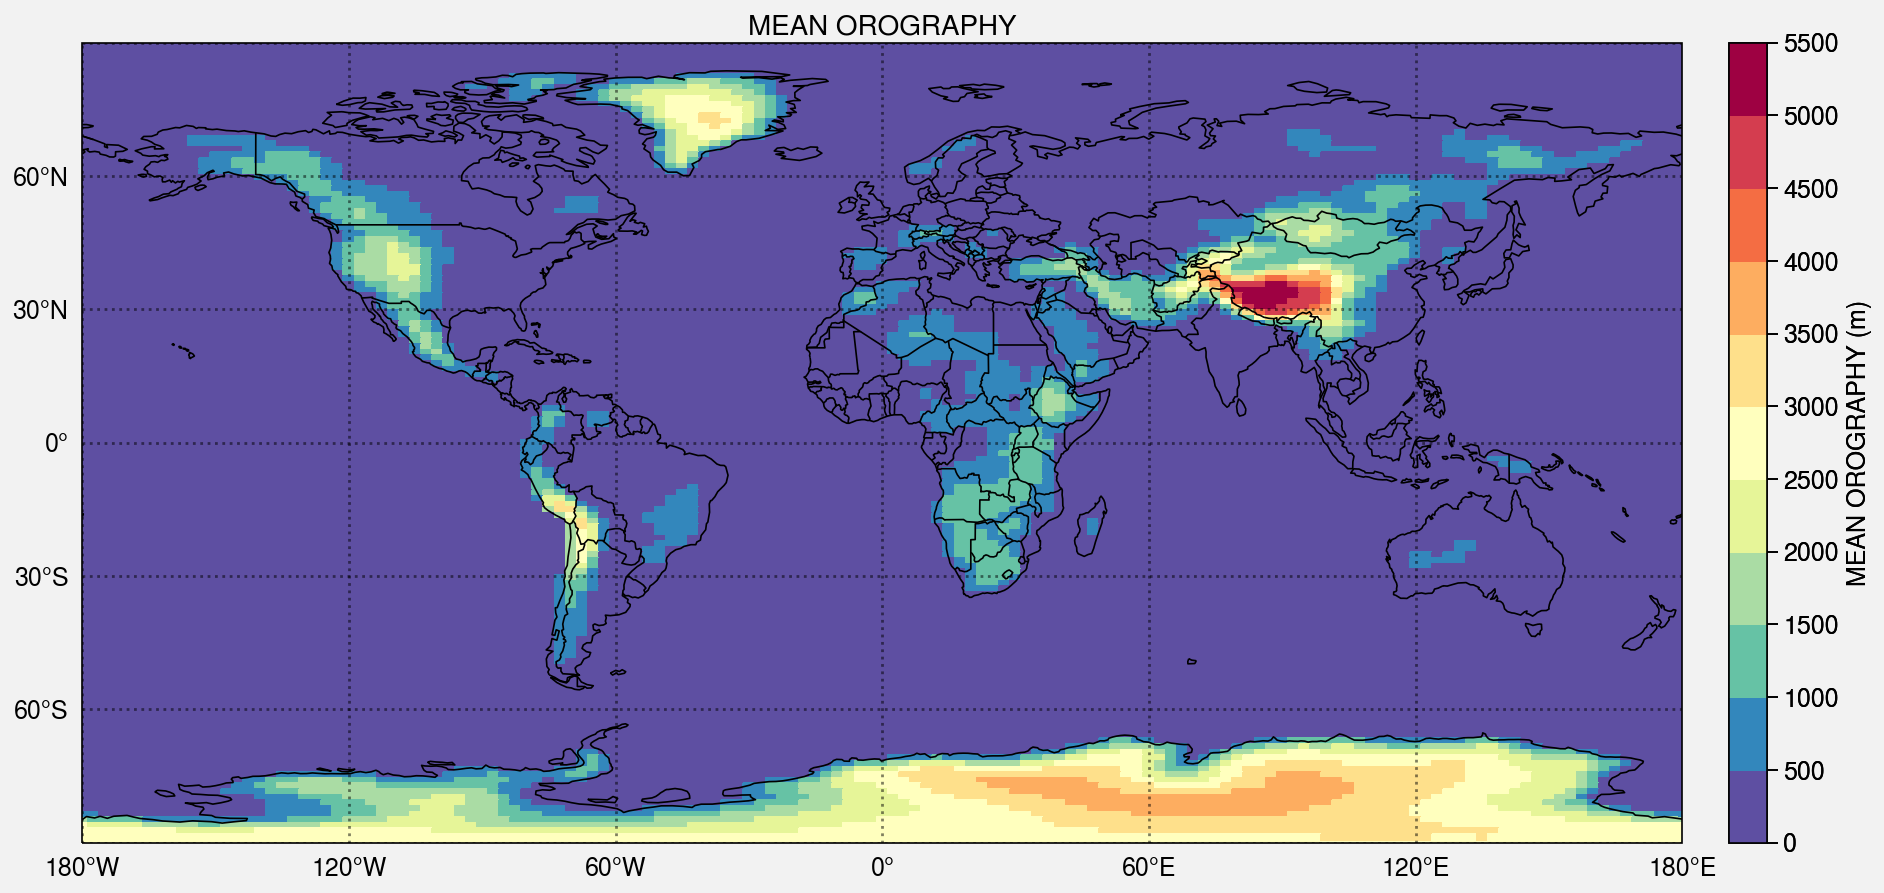

In [72]:
f, axs = plot.subplots(proj='cyl', ncols=1, nrows=1, axwidth=8)

axs[0].pcolormesh(topo, cmap='Spectral', colorbar='r')

axs.format(labels=True, coast=True, borders=True, lonlines=60, latlines=30)

In [73]:
topo_CMIP6 = xr.open_dataarray(
    '/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/fx/orog/gr/latest/orog_fx_IPSL-CM6A-LR_historical_r1i1p1f1_gr.nc'
)
topo_CMIP6

<xarray.DataArray 'orog' (lat: 143, lon: 144)>
array([[2841.648 , 2841.648 , 2841.648 , ..., 2841.648 , 2841.648 , 2841.648 ],
       [2688.9688, 2697.9724, 2708.5688, ..., 2658.9578, 2668.209 , 2677.9058],
       [2618.7102, 2638.589 , 2658.8015, ..., 2562.443 , 2580.6404, 2599.4429],
       ...,
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,    0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,    0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,    0.    ]],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 -90.0 -88.73239 -87.46479 ... 87.46479 88.73239 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    long_name:         Surface Altitude
    units:             m
    online_operation:  once
    cell_methods:      area: mean
    cell_measures:     area: areacella
    standard_name:     surface_altitude
    description:       The surface called 'surface' means the lower boundary ...

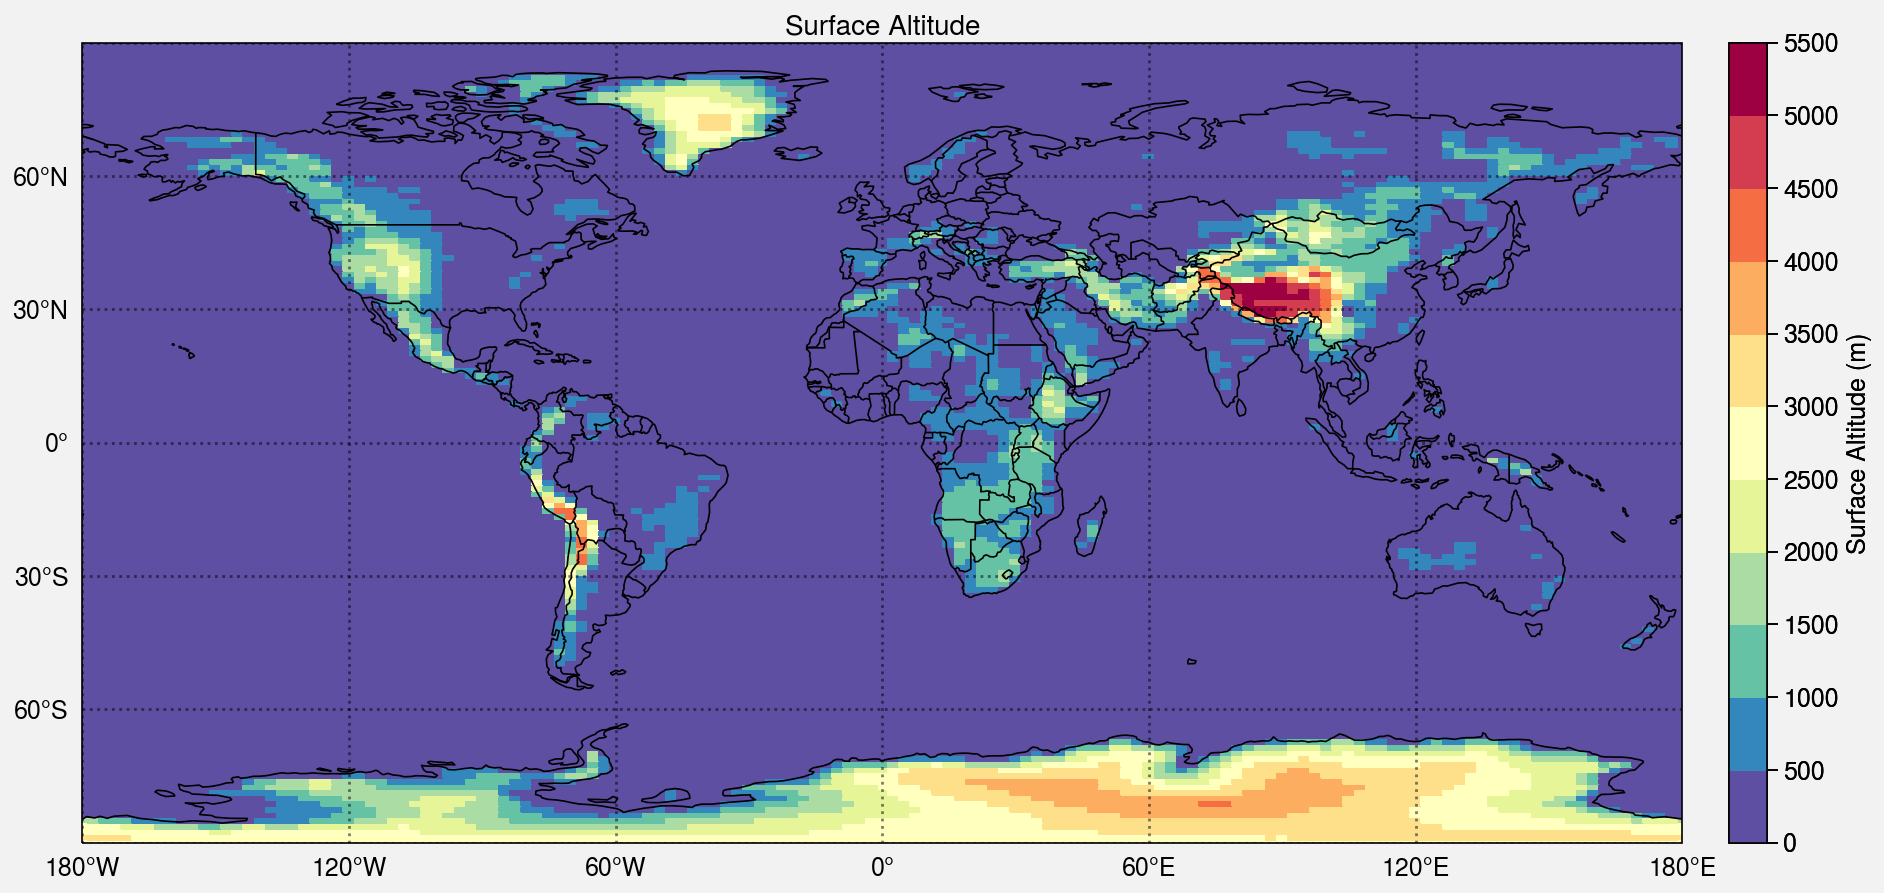

In [74]:
f, axs = plot.subplots(proj='cyl', ncols=1, nrows=1, axwidth=8)

axs[0].pcolormesh(topo_CMIP6, cmap='Spectral', colorbar='r')

axs.format(labels=True, coast=True, borders=True, lonlines=60, latlines=30)

In [79]:
topo_CMIP6.lon

<xarray.DataArray 'lon' (lon: 144)>
array([  0. ,   2.5,   5. ,   7.5,  10. ,  12.5,  15. ,  17.5,  20. ,  22.5,
        25. ,  27.5,  30. ,  32.5,  35. ,  37.5,  40. ,  42.5,  45. ,  47.5,
        50. ,  52.5,  55. ,  57.5,  60. ,  62.5,  65. ,  67.5,  70. ,  72.5,
        75. ,  77.5,  80. ,  82.5,  85. ,  87.5,  90. ,  92.5,  95. ,  97.5,
       100. , 102.5, 105. , 107.5, 110. , 112.5, 115. , 117.5, 120. , 122.5,
       125. , 127.5, 130. , 132.5, 135. , 137.5, 140. , 142.5, 145. , 147.5,
       150. , 152.5, 155. , 157.5, 160. , 162.5, 165. , 167.5, 170. , 172.5,
       175. , 177.5, 180. , 182.5, 185. , 187.5, 190. , 192.5, 195. , 197.5,
       200. , 202.5, 205. , 207.5, 210. , 212.5, 215. , 217.5, 220. , 222.5,
       225. , 227.5, 230. , 232.5, 235. , 237.5, 240. , 242.5, 245. , 247.5,
       250. , 252.5, 255. , 257.5, 260. , 262.5, 265. , 267.5, 270. , 272.5,
       275. , 277.5, 280. , 282.5, 285. , 287.5, 290. , 292.5, 295. , 297.5,
       300. , 302.5, 305. , 307.5, 310. , 312.5, 315. , 317.5, 320. , 322.5,
       325. , 327.5, 330. , 332.5, 335. , 337.5, 340. , 342.5, 345. , 347.5,
       350. , 352.5, 355. , 357.5], dtype=float32)
Coordinates:
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    axis:           X
    standard_name:  longitude
    long_name:      Longitude
    units:          degrees_east

In [81]:
topo_correct = topo_CMIP6.copy()

In [82]:
144/2

72.0

In [84]:
topo_correct[:,0:72] = topo[:,72:]

<xarray.DataArray 'orog' (lat: 143, lon: 72)>
array([[2841.648 , 2841.648 , 2841.648 , ..., 2841.648 , 2841.648 ,
        2841.648 ],
       [2688.9688, 2697.9724, 2708.5688, ..., 3016.303 , 3014.4456,
        3011.725 ],
       [2618.7102, 2638.589 , 2658.8015, ..., 2988.0059, 2973.084 ,
        2950.838 ],
       ...,
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -90.0 -88.73239 -87.46479 ... 87.46479 88.73239 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 170.0 172.5 175.0 177.5
Attributes:
    long_name:         Surface Altitude
    units:             m
    online_operation:  once
    cell_methods:      area: mean
    cell_measures:     area: areacella
    standard_name:     surface_altitude
    description:       The surface called 'surface' means the lower boundary ...

In [90]:
topo[:,:72]

<xarray.DataArray 'ZMEA' (latu: 143, lonv: 72)>
array([[   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       ...,
       [2881.2407, 2858.5525, 2832.5352, ..., 2575.9863, 2593.2441,
        2610.727 ],
       [2965.1213, 2953.5305, 2939.9067, ..., 2663.5703, 2673.3835,
        2683.9956],
       [2814.9966, 2814.9966, 2814.9966, ..., 2814.9966, 2814.9966,
        2814.9966]], dtype=float32)
Coordinates:
  * lonv     (lonv) float32 180.0 182.5 185.0 187.5 ... 350.0 352.5 355.0 357.5
  * latu     (latu) float32 90.0 88.73239 87.46479 ... -87.46479 -88.73239 -90.0
Attributes:
    units:      m
    long_name:  MEAN OROGRAPHY

In [91]:
topo_correct[:,72:] = topo[:,:72]

In [121]:
topo[-1:]

<xarray.DataArray 'ZMEA' (latu: 1, lonv: 144)>
array([[2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966,
        2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966,
        2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966,
        2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966,
        2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966,
        2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966,
        2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966,
        2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966,
        2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966,
        2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966,
        2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966,
        2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966,
        2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966,
        2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966,
        2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966,
        2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966,
        2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966,
        2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966,
        2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966,
        2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966,
        2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966,
        2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966,
        2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966,
        2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966, 2814.9966]],
      dtype=float32)
Coordinates:
  * lonv     (lonv) float32 180.0 182.5 185.0 187.5 ... 530.0 532.5 535.0 537.5
  * latu     (latu) float32 -90.0
Attributes:
    units:      m
    long_name:  MEAN OROGRAPHY

In [97]:
topo[-1:0]

<xarray.DataArray 'ZMEA' (latu: 0, lonv: 144)>
array([], shape=(0, 144), dtype=float32)
Coordinates:
  * lonv     (lonv) float32 180.0 182.5 185.0 187.5 ... 530.0 532.5 535.0 537.5
  * latu     (latu) float32 
Attributes:
    units:      m
    long_name:  MEAN OROGRAPHY

In [109]:
topo.roll(lonv=72, roll_coords=True)

<xarray.DataArray 'ZMEA' (latu: 143, lonv: 144)>
array([[   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       ...,
       [2628.484 , 2646.412 , 2664.673 , ..., 2575.9863, 2593.2441,
        2610.727 ],
       [2695.0745, 2705.592 , 2716.1943, ..., 2663.5703, 2673.3835,
        2683.9956],
       [2814.9966, 2814.9966, 2814.9966, ..., 2814.9966, 2814.9966,
        2814.9966]], dtype=float32)
Coordinates:
  * lonv     (lonv) float32 360.0 362.5 365.0 367.5 ... 350.0 352.5 355.0 357.5
  * latu     (latu) float32 90.0 88.73239 87.46479 ... -87.46479 -88.73239 -90.0
Attributes:
    units:      m
    long_name:  MEAN OROGRAPHY

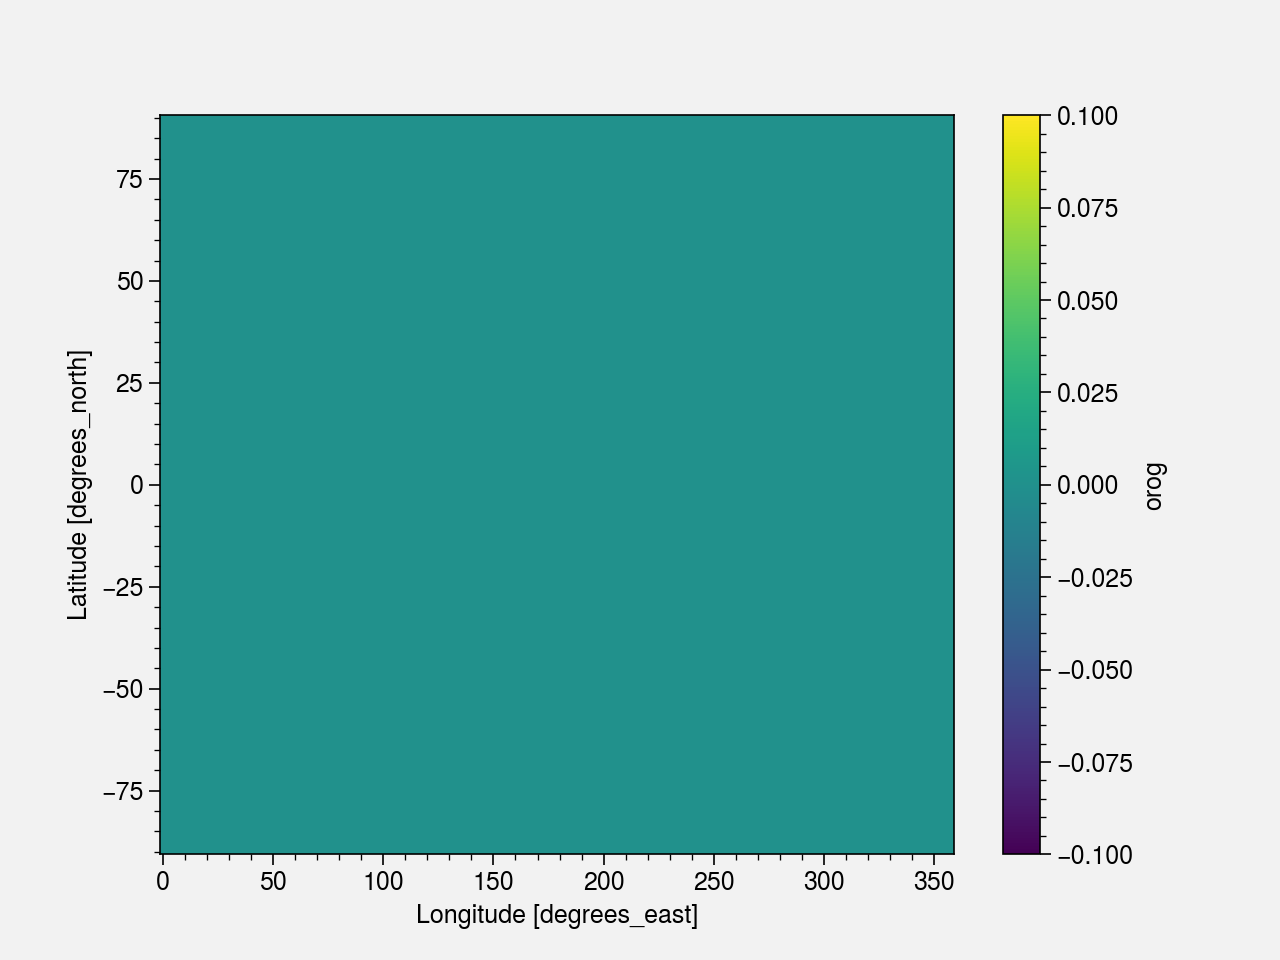

In [113]:
(topo_correct - topo.roll(lonv=72, roll_coords=True).values)

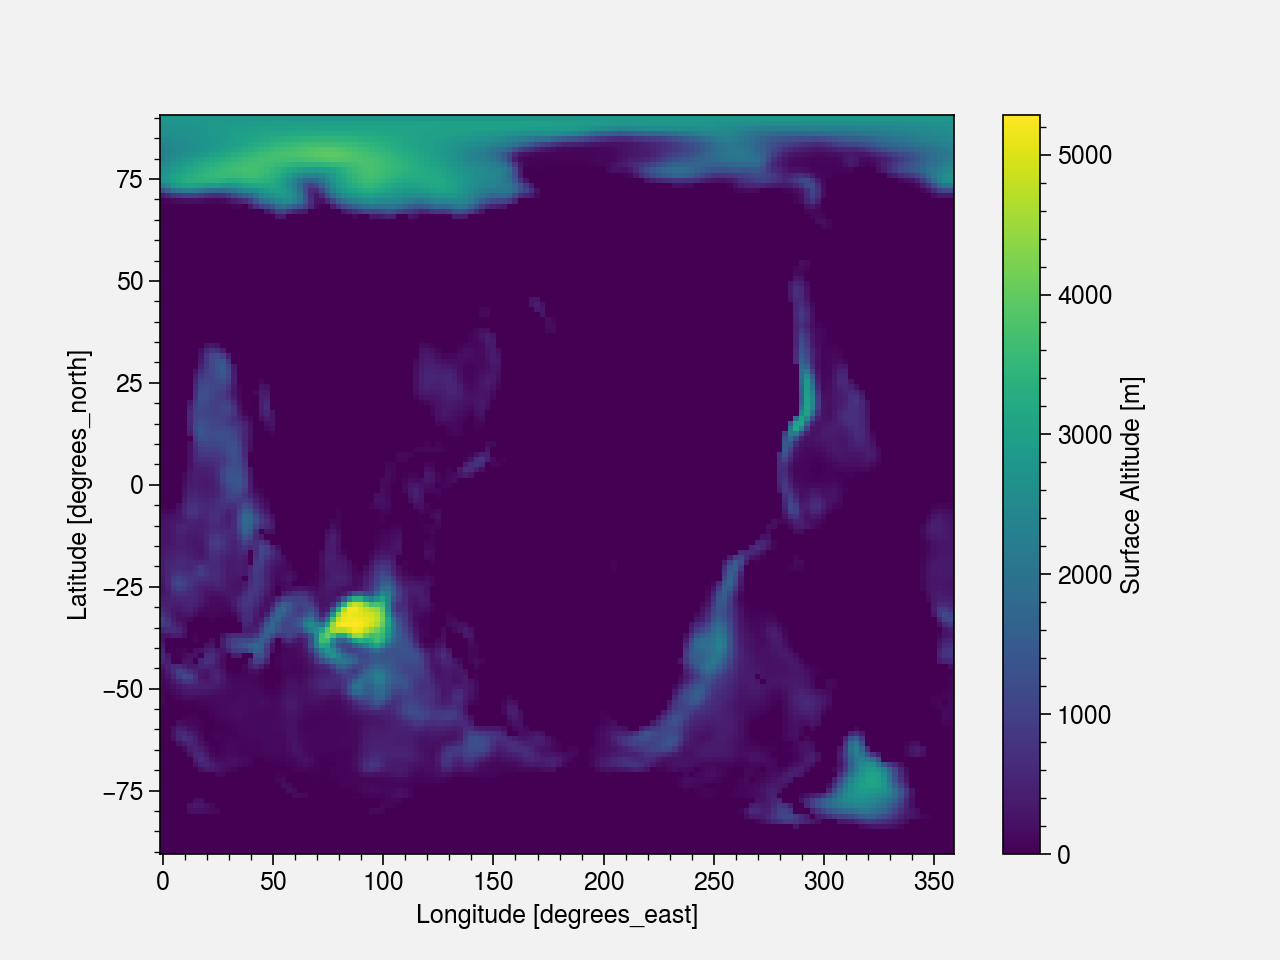

In [117]:
topo_correct.plot()

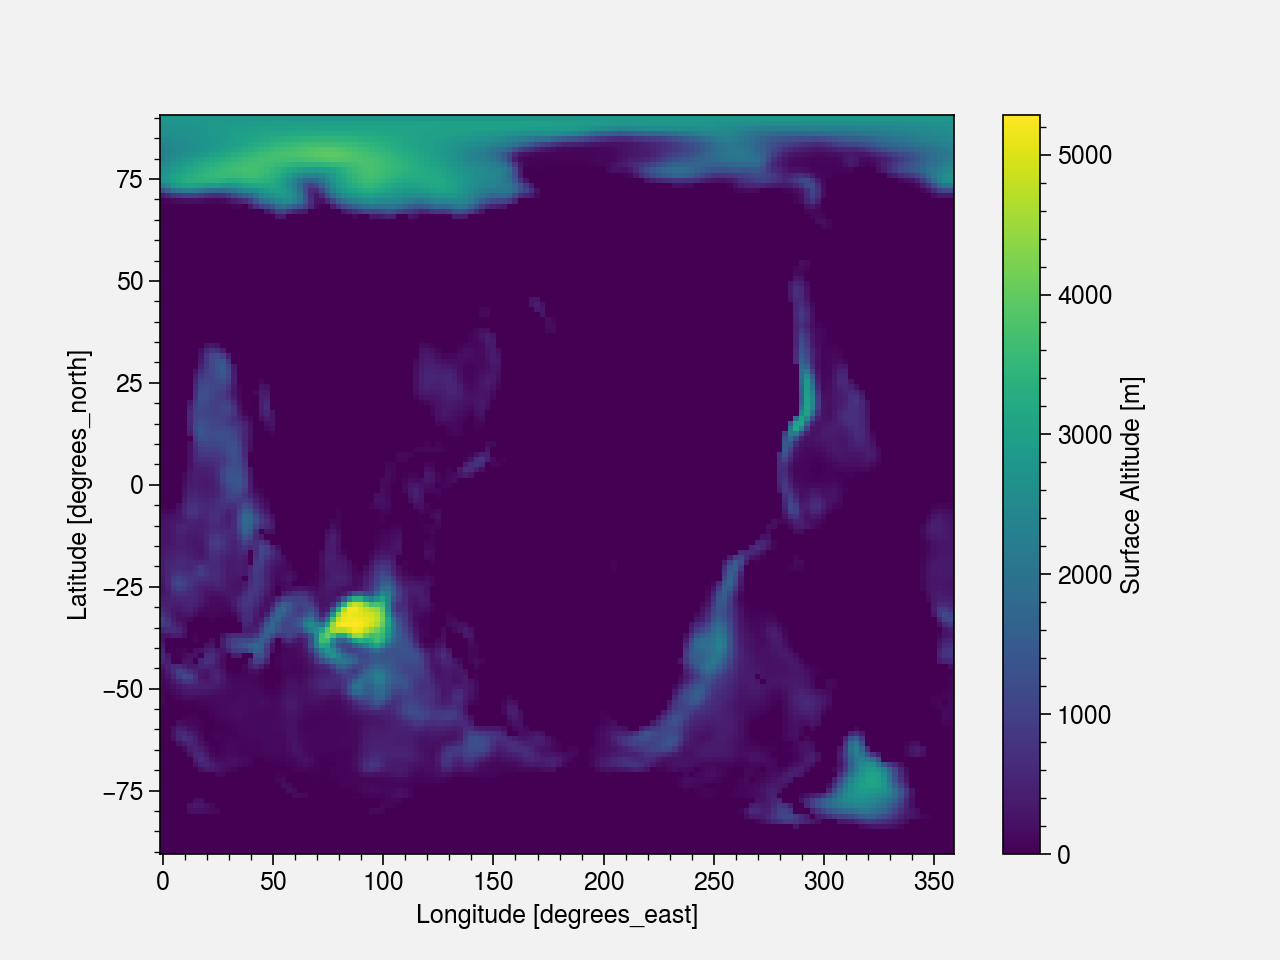

In [116]:
topo_correct.sortby('lat').plot()

In [125]:
topo.sortby('latu').values

array([[2814.9966, 2814.9966, 2814.9966, ..., 2814.9966, 2814.9966,
        2814.9966],
       [2965.1213, 2953.5305, 2939.9067, ..., 2979.02  , 2974.8362,
        2971.2524],
       [2881.2407, 2858.5525, 2832.5352, ..., 2904.9102, 2906.1929,
        2898.6482],
       ...,
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ]], dtype=float32)

In [94]:
# Put lat in the same order
for lat in range(topo_correct.lat.size):
topo_correct[0]

<xarray.DataArray 'orog' (lon: 144)>
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)
Coordinates:
    lat      float32 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    long_name:         Surface Altitude
    units:             m
    online_operation:  once
    cell_methods:      area: mean
    cell_measures:     area: areacella
    standard_name:     surface_altitude
    description:       The surface called 'surface' means the lower boundary ...

In [86]:
topo.lonv[72:]

<xarray.DataArray 'lonv' (lonv: 72)>
array([360. , 362.5, 365. , 367.5, 370. , 372.5, 375. , 377.5, 380. , 382.5,
       385. , 387.5, 390. , 392.5, 395. , 397.5, 400. , 402.5, 405. , 407.5,
       410. , 412.5, 415. , 417.5, 420. , 422.5, 425. , 427.5, 430. , 432.5,
       435. , 437.5, 440. , 442.5, 445. , 447.5, 450. , 452.5, 455. , 457.5,
       460. , 462.5, 465. , 467.5, 470. , 472.5, 475. , 477.5, 480. , 482.5,
       485. , 487.5, 490. , 492.5, 495. , 497.5, 500. , 502.5, 505. , 507.5,
       510. , 512.5, 515. , 517.5, 520. , 522.5, 525. , 527.5, 530. , 532.5,
       535. , 537.5], dtype=float32)
Coordinates:
  * lonv     (lonv) float32 360.0 362.5 365.0 367.5 ... 530.0 532.5 535.0 537.5
Attributes:
    units:      degrees_east
    long_name:  Longitude

In [138]:
test = topo_CMIP6.copy()

http://xarray.pydata.org/en/stable/reshaping.html

In [140]:
# Shift the data the right longitude + order the latitude from -90 to 90 (format CMIP6 topo)
test.values = topo.roll(lonv=int(topo_CMIP6.lon.size/2), roll_coords=True).sortby('latu').values

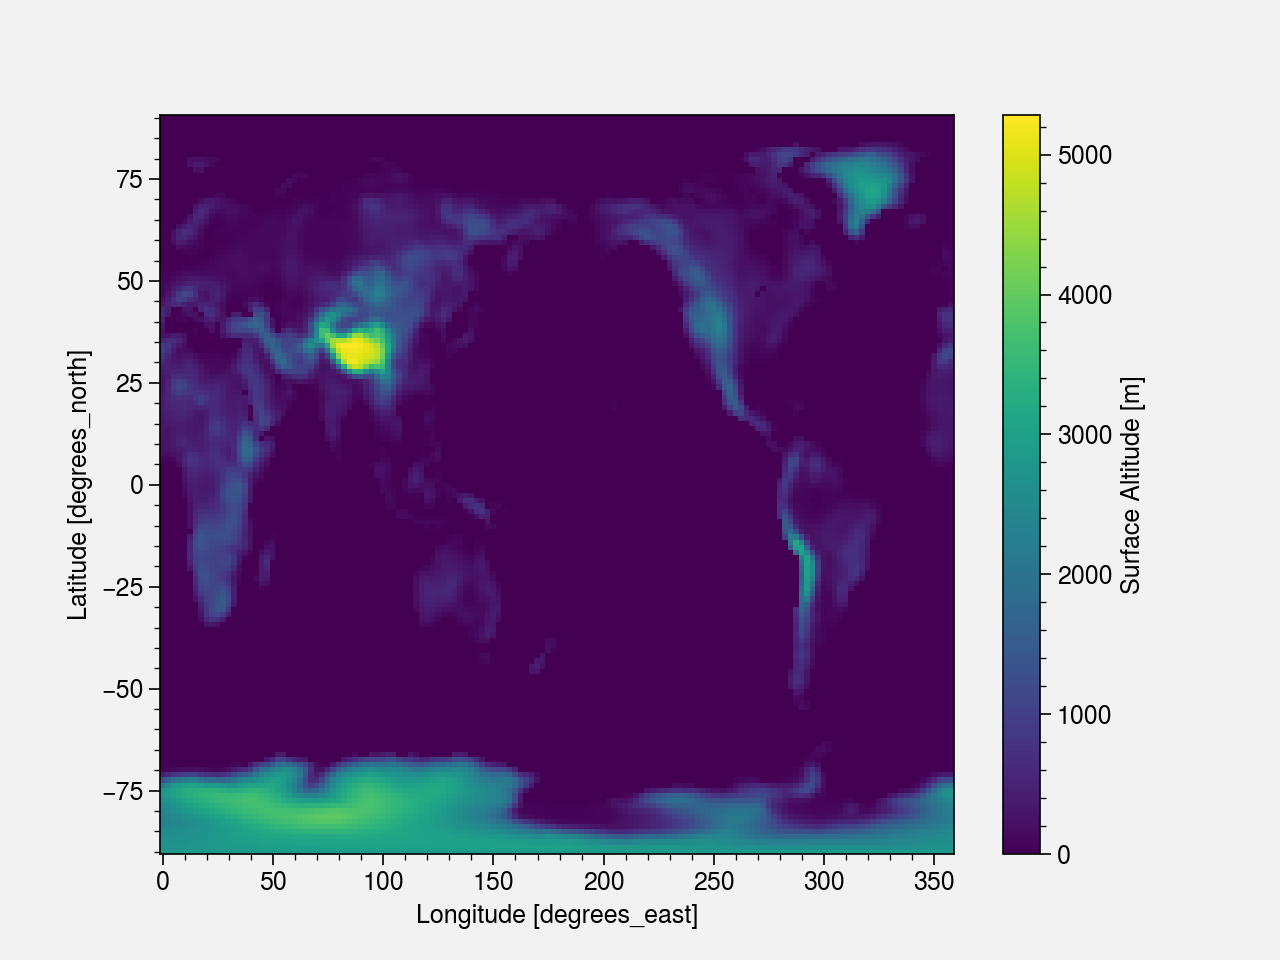

In [142]:
test.plot()

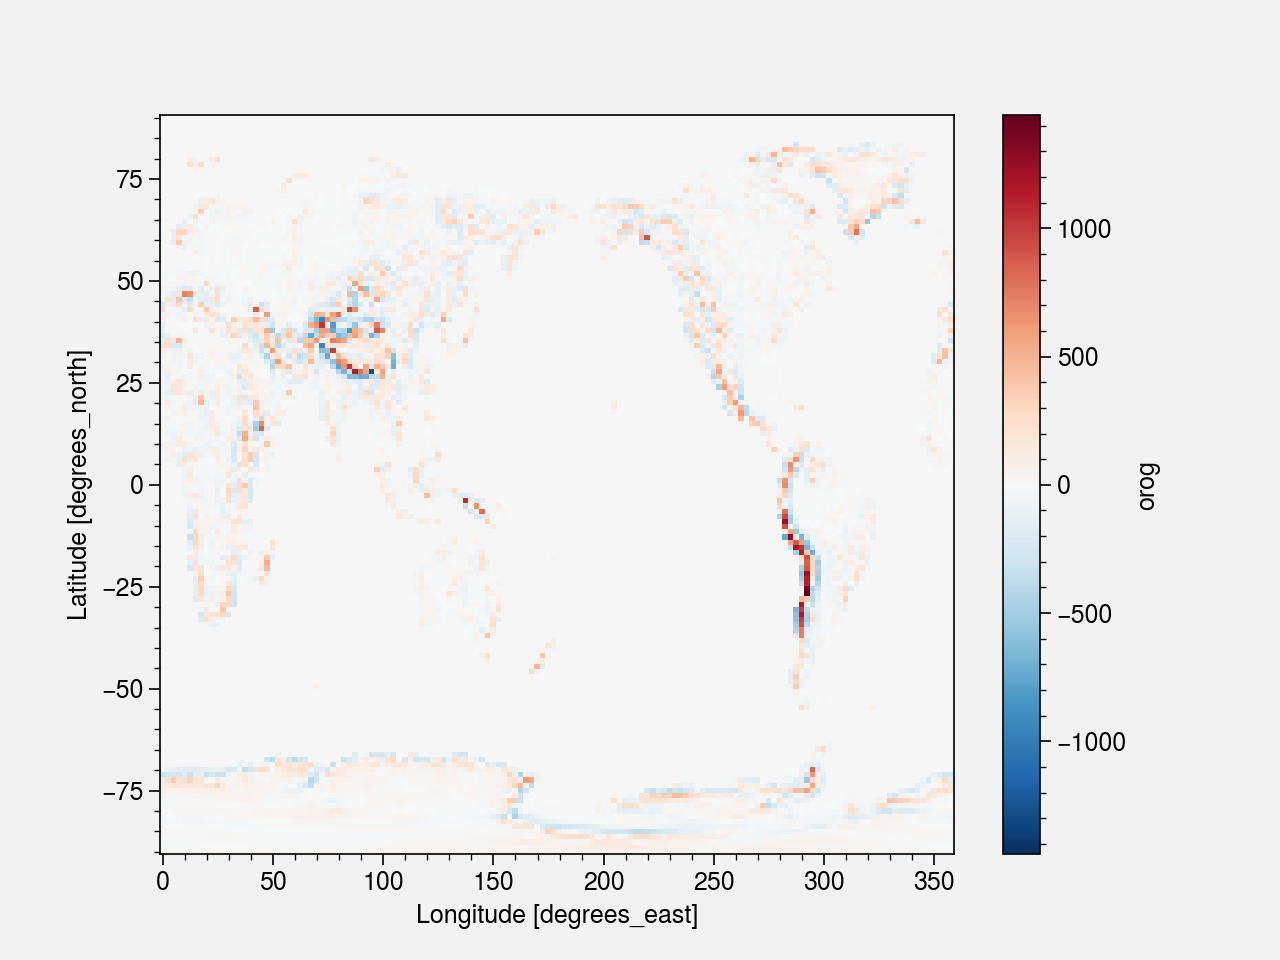

In [143]:
(topo_CMIP6 - test).plot()

In [146]:
# File computed (by hand) from GLOBE 1 km
mean_topo = xr.open_dataarray('/home/mlalande/notebooks/CICLAD/Himalaya/CMIP6_IPSL_bias/mean_topo.nc')
mean_topo

<xarray.DataArray 'orog' (lat: 143, lon: 144)>
array([[2766.2896, 2768.7498, 2771.2778, ..., 2760.2864, 2762.1475, 2762.1475],
       [2679.6423, 2688.095 , 2696.1418, ..., 2656.141 , 2663.1135, 2663.1135],
       [2600.3545, 2619.7944, 2648.6519, ..., 2556.7124, 2571.3628, 2571.3628],
       ...,
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,    0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,    0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,    0.    ]],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 -90.0 -88.73239 -87.46479 ... 87.46479 88.73239 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    long_name:         Surface Altitude
    units:             m
    online_operation:  once
    cell_methods:      area: mean
    cell_measures:     area: areacella
    standard_name:     surface_altitude
    description:       The surface called 'surface' means the lower boundary ...

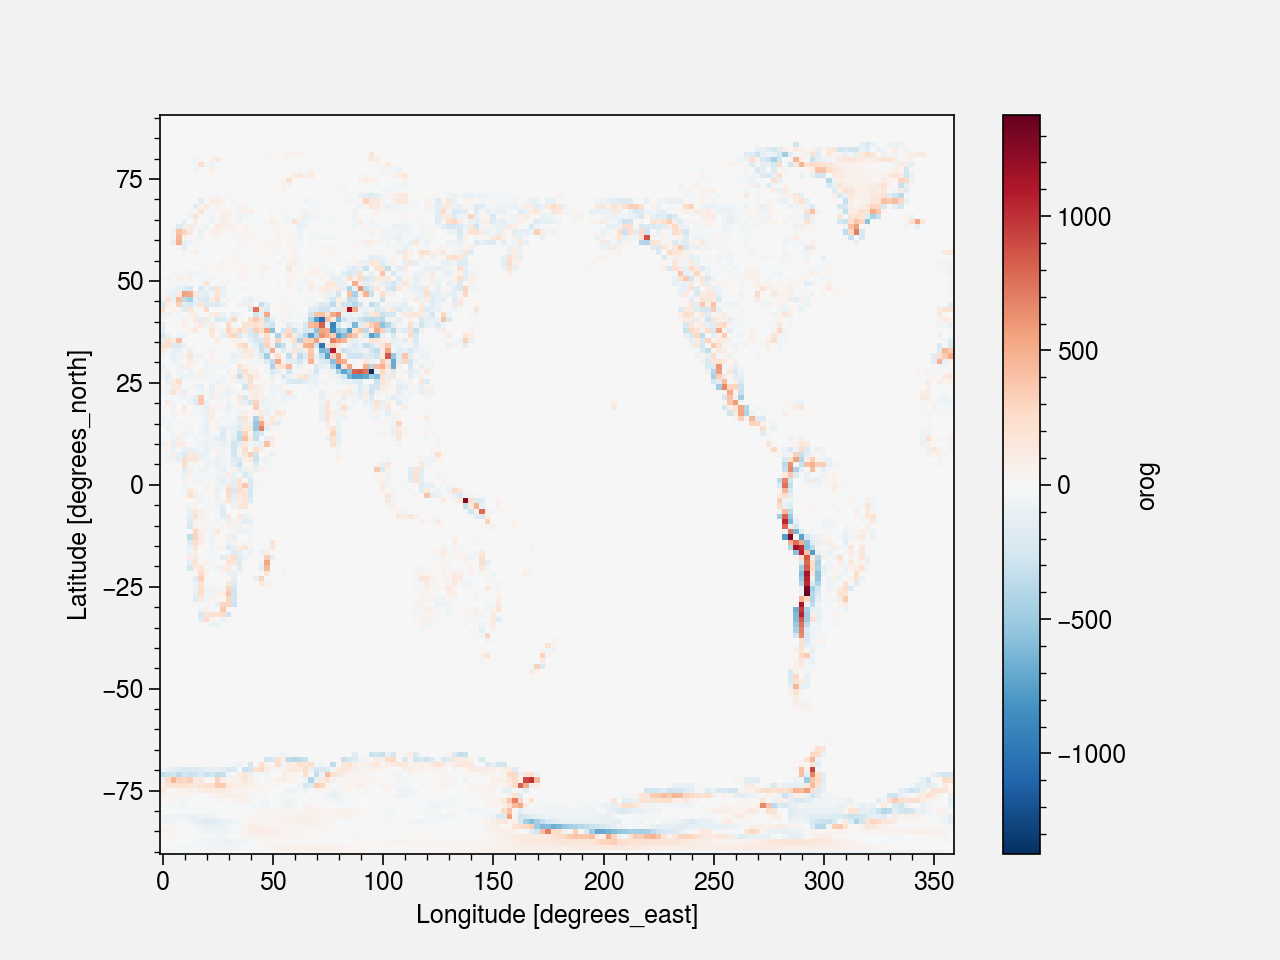

In [149]:
(mean_topo - test).plot()

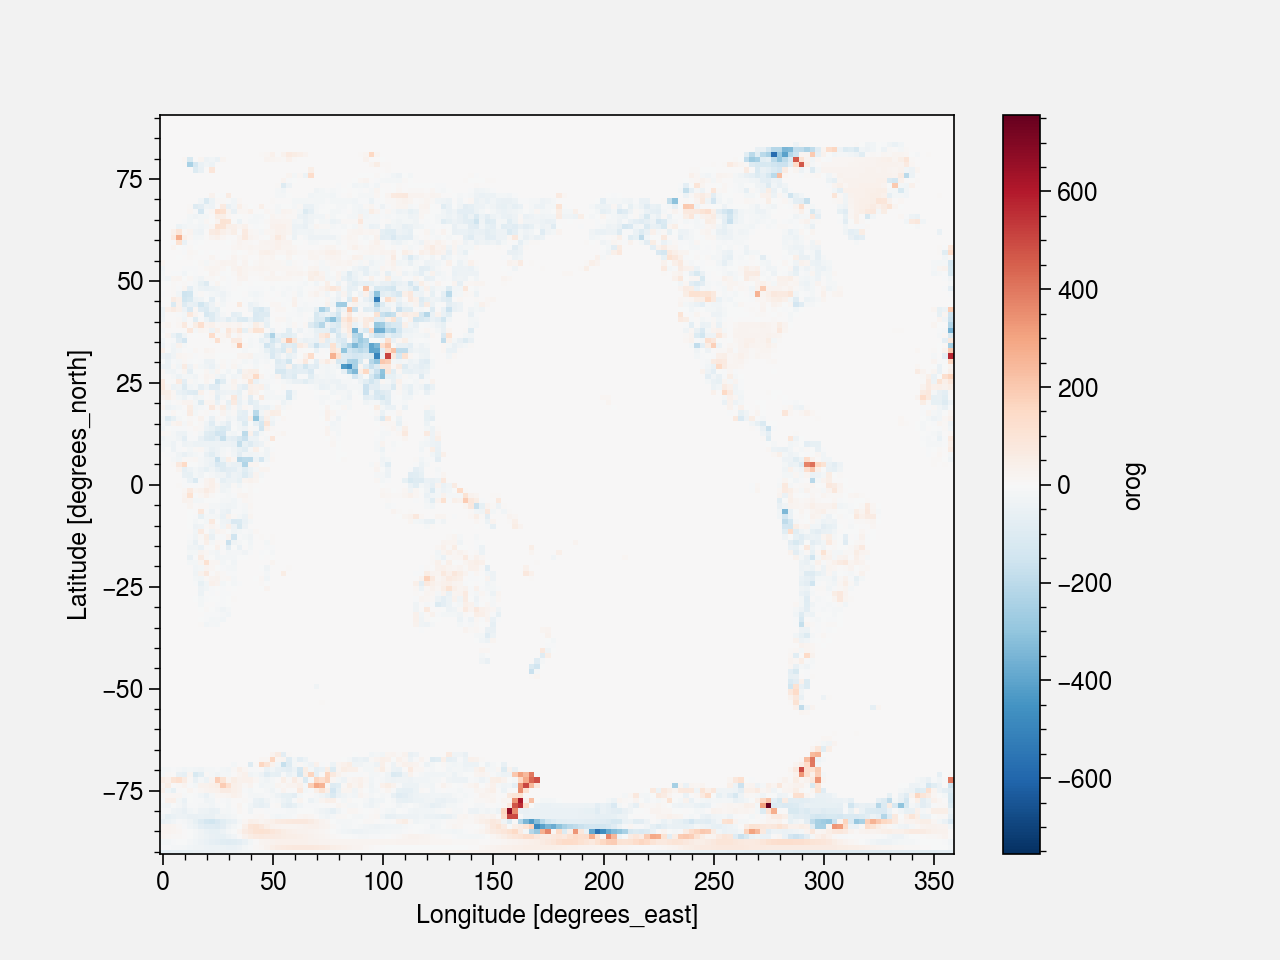

In [150]:
(mean_topo - topo_CMIP6).plot()